In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from torchvision import transforms

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2 
import os
from PIL import Image

In [2]:
is_gpu_available = torch.cuda.is_available()
print(is_gpu_available)

True


Data preparation 



In [3]:
csv_file_path = r'C:\Users\hazem\OneDrive\Desktop\simulator\simulator-windows-64\last_final\driving_log.csv'

In [4]:
class CustomDataSet(Dataset):
    def __init__(self, csv_file, transform = None):
        self.df = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        images = Image.open(self.df.iloc[idx, 0])

        if self.transform:
            images =self.transform(images)

        steering_angle = self.df.iloc[idx, 3:4].values.astype(float)
        throttle = self.df.iloc[idx, 4:5].values.astype(float)

        return images, steering_angle, throttle

In [5]:
# Inputting image details
IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS = 160, 320, 3
INPUT_SHAPE = (IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS)

#Defining image transformations
data_transform = transforms.Compose([transforms.Resize((IMAGE_HEIGHT, IMAGE_WIDTH)),
                                    transforms.ToTensor(),transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])

In [6]:
dataset = CustomDataSet(csv_file_path, data_transform)

In [7]:
# Split the dataset into training and testing sets
train_size = 0.8  
test_size = 0.2

# Split the dataset into train and test sets
train_dataset, test_dataset = train_test_split(dataset, test_size=test_size, random_state=42)

# Create data loaders for training and testing
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Model Design


In [8]:
class SelfDrivingModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 24, 5, stride=2) #158*78*24
        self.conv2 = nn.Conv2d(24, 36, 5, stride=2) #77*37*36
        self.conv3 = nn.Conv2d(36, 48, 5, stride=2) #37*17*48
        self.pool = nn.MaxPool2d(2, 2) #18*8*48
        self.conv4 = nn.Conv2d(48, 64, 3) #16*6*64
        self.conv5 = nn.Conv2d(64, 64, 3) #14*4*64
        self.fc1 = nn.Linear(14*4*64, 100)
        self.fc2 = nn.Linear(100, 50)
        self.fc3 = nn.Linear(50, 10)
        self.fc4 = nn.Linear(10, 2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.fc4(x)
        return x

In [9]:
#make an instance of the model
model = SelfDrivingModel()

In [10]:
# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [11]:
# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


SelfDrivingModel(
  (conv1): Conv2d(3, 24, kernel_size=(5, 5), stride=(2, 2))
  (conv2): Conv2d(24, 36, kernel_size=(5, 5), stride=(2, 2))
  (conv3): Conv2d(36, 48, kernel_size=(5, 5), stride=(2, 2))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(48, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=3584, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=10, bias=True)
  (fc4): Linear(in_features=10, out_features=2, bias=True)
)

In [12]:
train_losses = []
# Training loop
for epoch in range(40):
    train_loss = 0.0

    for batch in train_loader:
        
        images, steering_angle, throttle = batch
        images = images.float().to(device)  # Ensure input data is a float tensor
        steering_angle = steering_angle.float().to(device)  # Ensure steering_angle is a float tensor
        throttle = throttle.float().to(device)  # Ensure throttle is a float tensor 

        # Zero the parameter gradients
        optimizer.zero_grad()
        # Forward pass through the model
        outputs = model(images)

        # Calculate the loss
        loss = criterion(outputs, torch.cat((steering_angle, throttle), dim=1).to(torch.float32))

        # Backpropagation and optimization
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # Calculate and print the average training loss for the epoch
    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f'Epoch [{epoch + 1}/{40}] - Train Loss: {avg_train_loss:.4f}')


Epoch [1/40] - Train Loss: 0.0389
Epoch [2/40] - Train Loss: 0.0250
Epoch [3/40] - Train Loss: 0.0240
Epoch [4/40] - Train Loss: 0.0231
Epoch [5/40] - Train Loss: 0.0213
Epoch [6/40] - Train Loss: 0.0203
Epoch [7/40] - Train Loss: 0.0205
Epoch [8/40] - Train Loss: 0.0204
Epoch [9/40] - Train Loss: 0.0194
Epoch [10/40] - Train Loss: 0.0191
Epoch [11/40] - Train Loss: 0.0186
Epoch [12/40] - Train Loss: 0.0182
Epoch [13/40] - Train Loss: 0.0177
Epoch [14/40] - Train Loss: 0.0166
Epoch [15/40] - Train Loss: 0.0158
Epoch [16/40] - Train Loss: 0.0145
Epoch [17/40] - Train Loss: 0.0131
Epoch [18/40] - Train Loss: 0.0115
Epoch [19/40] - Train Loss: 0.0100
Epoch [20/40] - Train Loss: 0.0083
Epoch [21/40] - Train Loss: 0.0067
Epoch [22/40] - Train Loss: 0.0050
Epoch [23/40] - Train Loss: 0.0038
Epoch [24/40] - Train Loss: 0.0034
Epoch [25/40] - Train Loss: 0.0026
Epoch [26/40] - Train Loss: 0.0020
Epoch [27/40] - Train Loss: 0.0019
Epoch [28/40] - Train Loss: 0.0014
Epoch [29/40] - Train Loss: 0

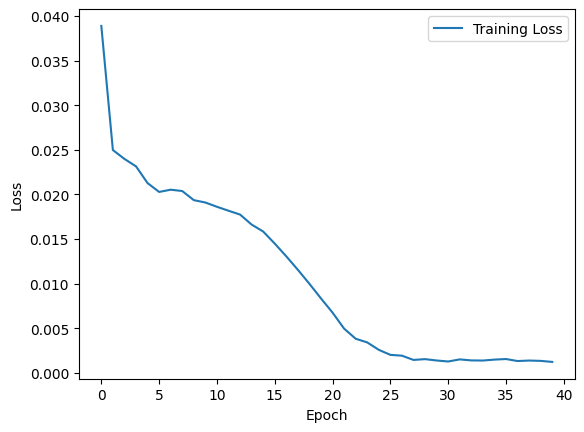

In [13]:
# Visualize the training loss
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [14]:
model.eval()  # Set model to evaluation mode
running_loss = 0.0
num_of_batches = 0.0

with torch.no_grad():
    for i, (images, steering_angle, throttle) in enumerate(test_loader):
        # Move images and labels to GPU 
        images = images.to(device)
        steering_angle = steering_angle.to(device)
        throttle = throttle.to(device)

        # Forward pass through the model
        preds = model(images)

        # Calculate the loss
        loss = criterion(preds, torch.cat((steering_angle, throttle), dim=1).to(torch.float32))

        running_loss += loss.item()
        num_of_batches += 1
        
        
       

# Calculate and return the average test loss
avg_test_loss = running_loss / num_of_batches
print(f'Average test loss: {avg_test_loss:.4f}')

Average test loss: 0.0200


In [15]:
# Save the model
torch.save(model, 'finalmodel.pth')